# Time series analysis of MRF stock prices using Python

Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from datetime import datetime


Fetch MRF Stock Data from Yahoo Finance

In [2]:
# Fetch data
mrf = yf.download('MRF.NS', start="2015-01-01", end="2024-01-01")

# mrf.reset_index(inplace=True)
mrf.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,37950.0,38320.000000,37848.351562,37981.351562,37399.441406,9595
2015-01-02,38150.0,38400.000000,37981.000000,38192.250000,37607.097656,11099
2015-01-05,38299.0,39390.000000,38000.000000,38477.300781,37887.785156,38178
2015-01-06,38350.0,38350.000000,37350.000000,37460.000000,36886.066406,15734
2015-01-07,37499.0,37724.949219,37011.000000,37381.050781,36808.339844,10795


Data Preprocessing

Missing values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<ipython-input-3-6e8d427b1a5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrf.rename(columns={'Close': 'Stock Price'}, inplace=True)


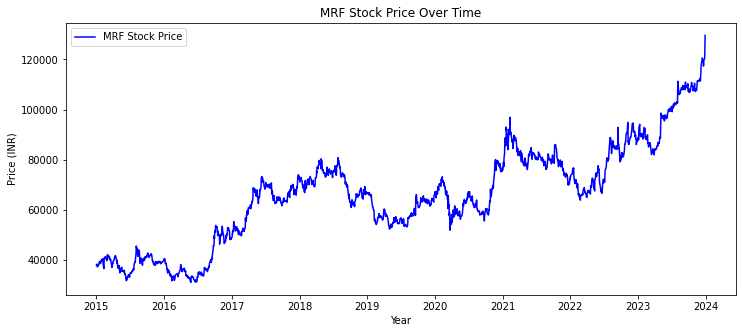

In [3]:
# Check for missing values
print("Missing values:\n", mrf.isnull().sum())

# Convert index to datetime format if not already
mrf.index = pd.to_datetime(mrf.index)

# Keep only the 'Close' price
mrf = mrf[['Close']]
mrf.rename(columns={'Close': 'Stock Price'}, inplace=True)

# Plot raw data
plt.figure(figsize=(12,5))
plt.plot(mrf, color='blue', label="MRF Stock Price")
plt.xlabel("Year")
plt.ylabel("Price (INR)")
plt.title("MRF Stock Price Over Time")
plt.legend()
plt.show()



Decompose with an additive model

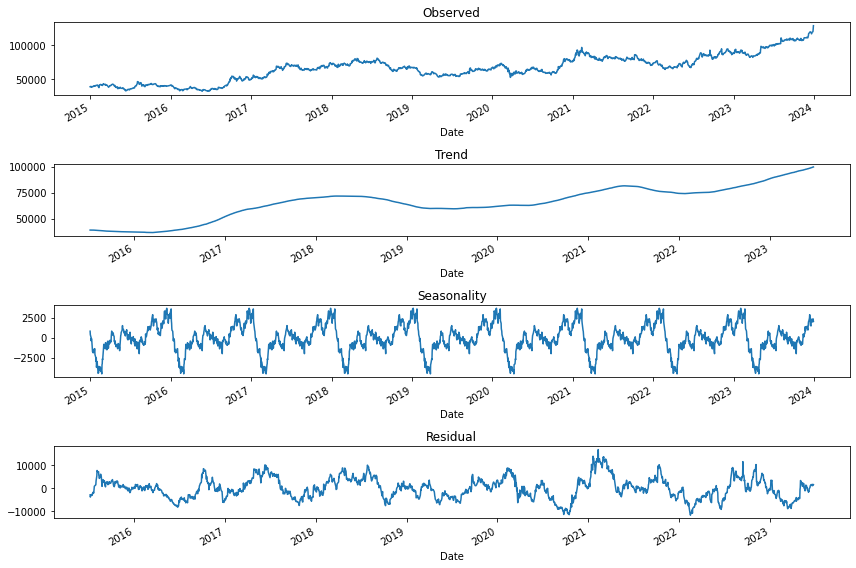

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose with an additive model
decomposed = seasonal_decompose(mrf, model='additive', period=252)  # Assuming ~252 trading days in a year

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12,8))

decomposed.observed.plot(ax=axes[0], title="Observed")
decomposed.trend.plot(ax=axes[1], title="Trend")
decomposed.seasonal.plot(ax=axes[2], title="Seasonality")
decomposed.resid.plot(ax=axes[3], title="Residual")

plt.tight_layout()
plt.show()


Check for Stationarity Using ADF Test

In [5]:
# Perform ADF Test
result = adfuller(mrf['Stock Price'])
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary, differencing is required.")


ADF Test Statistic: 0.3590413258444448
p-value: 0.9798968986281009
Critical Values: {'1%': -3.4333003744032, '5%': -2.8628433872007037, '10%': -2.5674638557393124}
The data is non-stationary, differencing is required.


Make Data Stationary (Differencing)

ADF Test Statistic (Differenced Data): -48.69099695731566
p-value: 0.0
The data is stationary.


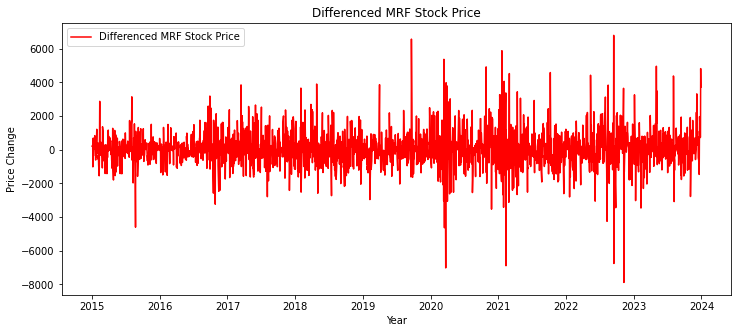

In [6]:
# First-order differencing
mrf_diff = mrf.diff().dropna()

# ADF test after differencing
result_diff = adfuller(mrf_diff['Stock Price'])
print("ADF Test Statistic (Differenced Data):", result_diff[0])
print("p-value:", result_diff[1])

if result_diff[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary, differencing is required.")

# Plot differenced data
plt.figure(figsize=(12,5))
plt.plot(mrf_diff, color='red', label="Differenced MRF Stock Price")
plt.xlabel("Year")
plt.ylabel("Price Change")
plt.title("Differenced MRF Stock Price")
plt.legend()
plt.show()


ACF and PACF Plots (Determine AR and MA components)

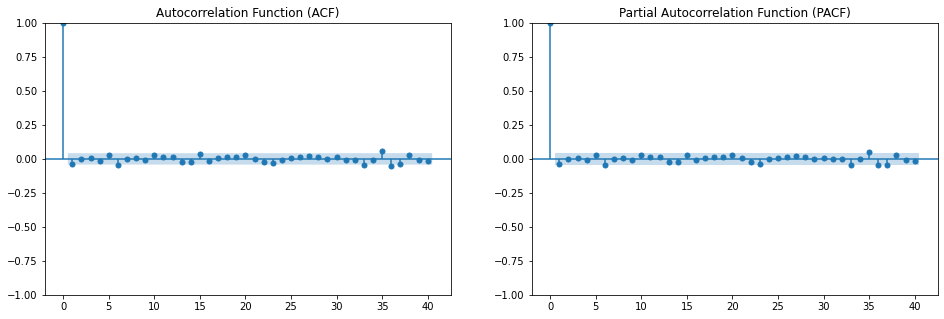

In [7]:
# ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(16,5))

plot_acf(mrf_diff, ax=axes[0], lags=40)
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(mrf_diff, ax=axes[1], lags=40)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


Auto ARIMA for Model Selection

In [8]:
# Auto ARIMA model
model_auto = auto_arima(mrf, seasonal=False, stepwise=True, trace=True)
print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37413.234, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37407.522, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37407.229, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37407.235, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37408.630, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37409.229, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37409.251, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37411.230, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37408.558, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.708 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2221
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -18700.614
Date:                Mon, 10 Feb 2025   

Fit the Best ARIMA Model

In [9]:
# Fit ARIMA based on Auto ARIMA results
p, d, q = model_auto.order
arima_model = sm.tsa.ARIMA(mrf, order=(p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:            Stock Price   No. Observations:                 2221
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -18702.279
Date:                Mon, 10 Feb 2025   AIC                          37408.558
Time:                        22:20:01   BIC                          37419.969
Sample:                             0   HQIC                         37412.726
                               - 2221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0284      0.013     -2.144      0.032      -0.054      -0.002
sigma2      1.216e+06   1.86e+04     65.391      0.000    1.18e+06    1.25e+06
Ljung-Box (L1) (Q):                   0.13   Jarque-

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


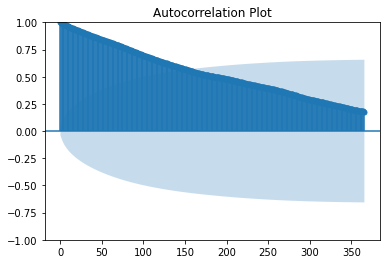

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mrf, lags=365)  # Checking for seasonality up to 1 year
plt.title("Autocorrelation Plot")
plt.show()


Fit SARIMA model

In [11]:
# Fit SARIMA model (if seasonality detected)
sarima_model = sm.tsa.SARIMAX(mrf, order=(p, d, q), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

print(sarima_result.summary())


c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          Stock Price   No. Observations:                 2221
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood              -18702.979
Date:                              Mon, 10 Feb 2025   AIC                          37413.958
Time:                                      22:20:07   BIC                          37436.757
Sample:                                           0   HQIC                         37422.287
                                             - 2221                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0270      0.014     -1.924      0.054      -0.054       0.001
ar.S.L12       0.08

Forecast Future Prices ARIMA model

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


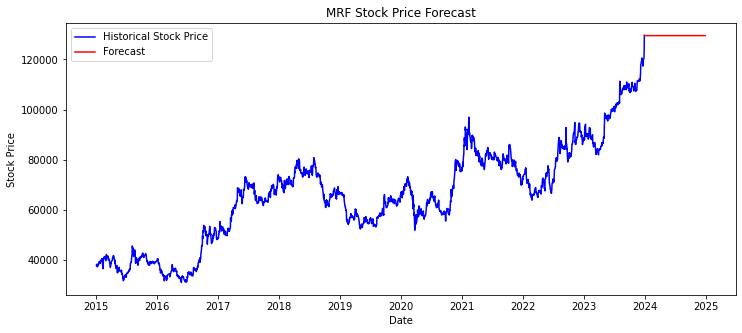

In [12]:
# Forecast next 365 days
forecast_steps = 365
forecast = arima_result.forecast(steps=forecast_steps)


# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(mrf, label="Historical Stock Price", color="blue")
plt.plot(pd.date_range(mrf.index[-1], periods=forecast_steps, freq="D"), 
         forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("MRF Stock Price Forecast")
plt.legend()
plt.show()


Forecast Future Prices SARIMA model

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


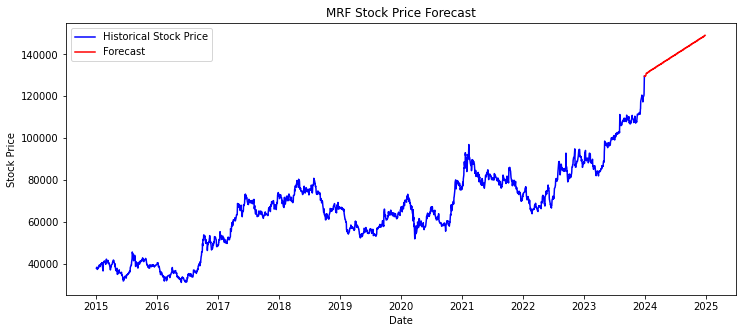

In [13]:
# Forecast next 365 days
forecast_steps = 365

forecast = sarima_result.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(mrf, label="Historical Stock Price", color="blue")
plt.plot(pd.date_range(mrf.index[-1], periods=forecast_steps, freq="D"), 
         forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("MRF Stock Price Forecast")
plt.legend()
plt.show()

Compare AIC & BIC for ARIMA and SARIMA

In [14]:
print("ARIMA Model AIC:", arima_result.aic)
print("ARIMA Model BIC:", arima_result.bic)

print("SARIMA Model AIC:", sarima_result.aic)
print("SARIMA Model BIC:", sarima_result.bic)


ARIMA Model AIC: 37408.558081045674
ARIMA Model BIC: 37419.968605995404
SARIMA Model AIC: 37413.95760340041
SARIMA Model BIC: 37436.75697303


Model	AIC (Lower is Better)	BIC (Lower is Better)

ARIMA	37408.56 ✅	            37419.97 ✅

SARIMA	37413.96 ❌	            37436.75 ❌

📌 Interpretation

✅ ARIMA is the better model because:

Lower AIC (37408.56 vs. 37413.96) → ARIMA provides a better fit.

Lower BIC (37419.97 vs. 37436.75) → ARIMA is preferred, especially considering model complexity.


What This Means?

Since SARIMA has a higher AIC and BIC, this suggests seasonality is not significantly improving the model.

ARIMA is sufficient to capture the patterns in the MRF stock price data.
Using SARIMA adds unnecessary complexity without improving model fit.


RMSE (Root Mean Square Error) for ARIMA & SARIMA

In [15]:
from sklearn.metrics import mean_squared_error

# Get predictions for ARIMA
arima_predictions = arima_result.predict(start=0, end=len(mrf)-1)
sarima_predictions = sarima_result.predict(start=0, end=len(mrf)-1)

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(mrf, arima_predictions))
sarima_rmse = np.sqrt(mean_squared_error(mrf, sarima_predictions))

print("ARIMA RMSE:", arima_rmse)
print("SARIMA RMSE:", sarima_rmse)


ARIMA RMSE: 1365.6155823454367
SARIMA RMSE: 1468.1356532544232



Model	AIC (Lower Better)	BIC (Lower Better)	RMSE (Lower Better)

ARIMA	37408.56 ✅	        37419.97 ✅	        1365.62 ✅

SARIMA	37413.96 ❌	        37436.75 ❌	        1468.14 ❌


📌 Interpretation
✅ ARIMA is the better model because:

Lower AIC (37408.56 vs. 37413.96) → ARIMA provides a better fit.

Lower BIC (37419.97 vs. 37436.75) → ARIMA is simpler and avoids overfitting.

Lower RMSE (1365.62 vs. 1468.14) → ARIMA makes more accurate predictions.

📌 SARIMA does not improve predictions, which suggests that seasonality is not a strong factor in MRF stock price movements.


MAPE (Mean Absolute Percentage Error)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
arima_mape = mean_absolute_percentage_error(mrf['Stock Price'], arima_predictions)
sarima_mape = mean_absolute_percentage_error(mrf['Stock Price'], sarima_predictions)

print("ARIMA MAPE:", arima_mape)
print("SARIMA MAPE:", sarima_mape)


ARIMA MAPE: 1.2140562558687835
SARIMA MAPE: 1.3175308278738194



Model	AIC (Lower Better)	BIC (Lower Better)	RMSE (Lower Better)	MAPE (Lower Better)

ARIMA	37408.56 ✅	37419.97 ✅	1365.62 ✅	1.214% ✅

SARIMA	37413.96 ❌	37436.75 ❌	1468.14 ❌	1.318% ❌

📌 Interpretation

✅ ARIMA is the better model because:

Lower AIC (37408.56 vs. 37413.96) → ARIMA provides a better fit.

Lower BIC (37419.97 vs. 37436.75) → ARIMA is simpler and avoids overfitting.

Lower RMSE (1365.62 vs. 1468.14) → ARIMA makes more accurate predictions.

Lower MAPE (1.214% vs. 1.318%) → ARIMA has a lower percentage error, making it more reliable for forecasting.

📌 SARIMA does not provide better performance, meaning seasonality is not a major factor in MRF stock price movement.



Residual Analysis (Check Model Fit)

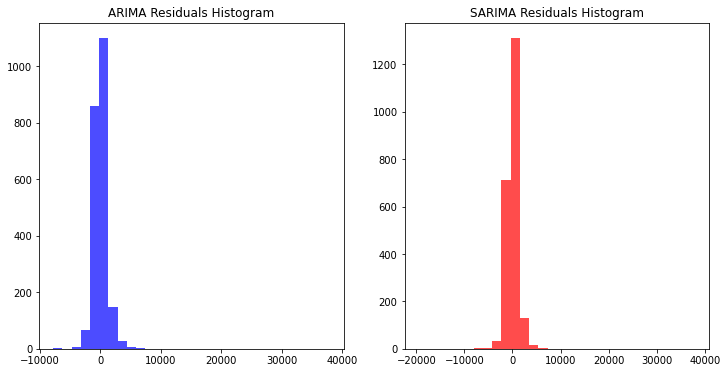

In [17]:
# Plot residuals for ARIMA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(arima_result.resid, bins=30, color="blue", alpha=0.7)
plt.title("ARIMA Residuals Histogram")

# Plot residuals for SARIMA
plt.subplot(1, 2, 2)
plt.hist(sarima_result.resid, bins=30, color="red", alpha=0.7)
plt.title("SARIMA Residuals Histogram")

plt.show()


Residuals Distribution

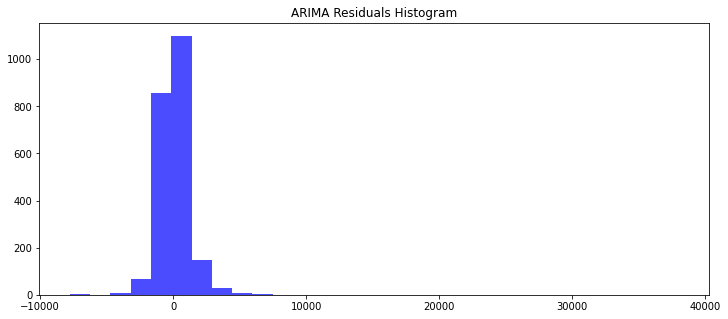

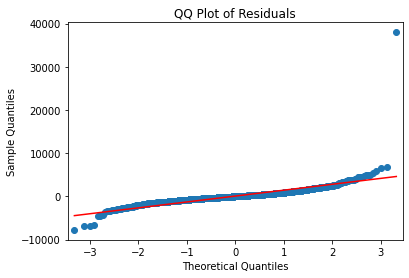

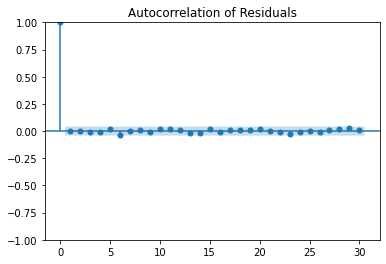

In [18]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram of residuals
plt.figure(figsize=(12, 5))
plt.hist(arima_result.resid, bins=30, color="blue", alpha=0.7)
plt.title("ARIMA Residuals Histogram")
plt.show()

# QQ Plot (Check if residuals follow a normal distribution)
sm.qqplot(arima_result.resid, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

# Check for Autocorrelation in Residuals
sm.graphics.tsa.plot_acf(arima_result.resid, lags=30)
plt.title("Autocorrelation of Residuals")
plt.show()
